In [39]:
%pip install -r requirements.txt -q

Note: you may need to restart the kernel to use updated packages.


In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt,spectrogram

In [41]:
# Low-pass filter configuration
cutoff_freq = 2.5  # Hz
T=.004 #seconds, from DAQ
sampling_rate = 1/T
nyquist_rate = sampling_rate / 2.0
b, a = butter(4, cutoff_freq / nyquist_rate, btype='low')

In [42]:
csv_files = ["EMRTC_Data_AS/20241025_MLO_DCI_S1.csv",
            "EMRTC_Data_AS/202421025_MLO_DCV_S1.csv",
            "EMRTC_Data_AS/20241025_MLO_DCI_S2.csv",
            "EMRTC_Data_AS/20241025_MLO_DCV_S2.csv"]
titles = ["S1 Current", "S1 Voltage", "S2 Current", "S2 Voltage"]

T=.004
dfs=[]
for i, file in enumerate(csv_files):
    df = pd.read_csv(file, header=None, skiprows=4)
    df.drop(df.columns[[2,4,6]], axis=1, inplace=True)
    df.columns = ['Time', 'A0', 'A1','A2','A3']
    df.drop(columns=['A0','A2', 'A3'], axis=1, inplace=True)
    df['A1_filt'] = filtfilt(b, a, df['A1']) # Apply LP filter
    df.loc[df['Time'] < 0.5, 'A1_filt'] = None #remove first 0.5 seconds of data to avoid filter transients
    dfs.append(df)

dfs[0]

,Time,A1,A1_filt
0,0.000,1.037121e-06,NaN
1,0.004,1.037121e-06,NaN
2,0.008,1.037121e-06,NaN
3,0.012,-2.980232e-08,NaN
4,0.016,-2.980232e-08,NaN
...,...,...,...
11385,45.540,3.099442e-07,-1.026308e-07
11386,45.544,3.099442e-07,-1.029556e-07
11387,45.548,3.099442e-07,-1.032265e-07
11388,45.552,-6.288290e-07,-1.034496e-07


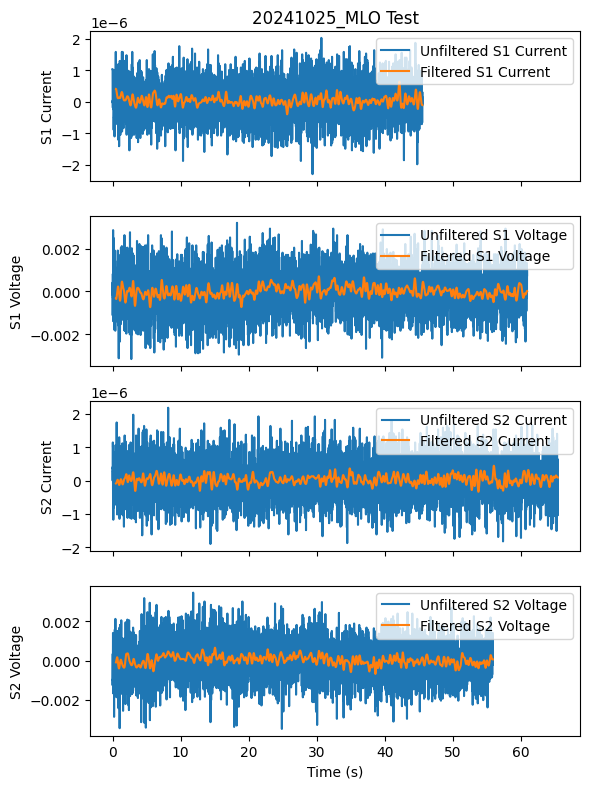

In [43]:
fig, axs = plt.subplots(4, 1, figsize=(6, 8), sharex=True)

for i, df in enumerate(dfs):
    axs[i].plot(df['Time'], df['A1'], label='Unfiltered '+titles[i])
    axs[i].plot(df['Time'], df['A1_filt'], label='Filtered '+titles[i])
    axs[i].set_ylabel(titles[i])
    axs[i].legend(loc='upper right')

axs[-1].set_xlabel('Time (s)')
axs[0].set_title("20241025_MLO Test")
plt.tight_layout()
plt.show()

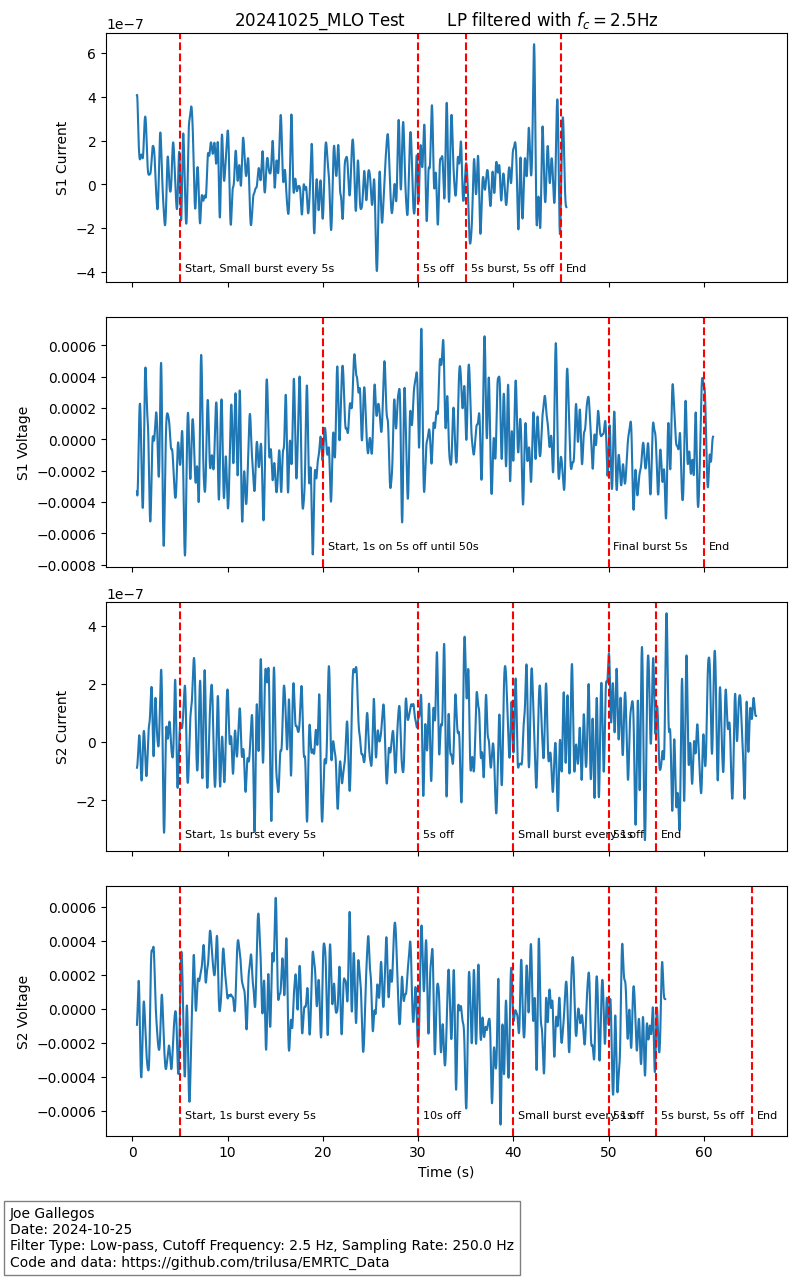

In [44]:

fig, axs = plt.subplots(4, 1, figsize=(8, 12), sharex=True)

events = [
    [(5, "Start, Small burst every 5s"), (30, "5s off"), (35, "5s burst, 5s off"), (45, "End")], #s1 I
    [(20, "Start, 1s on 5s off until 50s"), (50, "Final burst 5s"), (60, "End")], #s1 V,
    [(5, "Start, 1s burst every 5s"), (30, "5s off"), (40, "Small burst every 1s"), (50, "5s off"), (55, "End")], #s2 I
    [(5, "Start, 1s burst every 5s"), (30, "10s off"), (40, "Small burst every 1s"), (50, "5s off"), (55, "5s burst, 5s off"), (65, "End")], #s2 V
    
]

for i, (df, event_list) in enumerate(zip(dfs, events)):
    axs[i].plot(df['Time'], df['A1_filt'], label=titles[i])
    axs[i].set_ylabel(titles[i])
    for time, description in event_list:
        axs[i].axvline(x=time, color='r', linestyle='--')
        axs[i].text(time+.5, axs[i].get_ylim()[0] - axs[i].get_ylim()[0] * 0.2, description, rotation=0, verticalalignment='top', fontsize=8)

axs[-1].set_xlabel('Time (s)')
axs[0].set_title(f"20241025_MLO Test\t LP filtered with $f_c={cutoff_freq}$Hz")
# plt.xlim(.5,65.5)


# Add metadata as a textbox below the plot
metadata = f'''Joe Gallegos
Date: 2024-10-25
Filter Type: Low-pass, Cutoff Frequency: {cutoff_freq} Hz, Sampling Rate: {sampling_rate} Hz
Code and data: https://github.com/trilusa/EMRTC_Data'''
bbox_props = dict(facecolor='white', alpha=0.5)
fig.subplots_adjust(bottom=.25)  # Adjust bottom space to fit the textbox
fig.text(0.01, -0.01, metadata, ha='left', va='top', fontsize=10, bbox=bbox_props)

plt.tight_layout()
plt.savefig("20241025_MLO_Test.pdf", bbox_inches='tight')
plt.show()


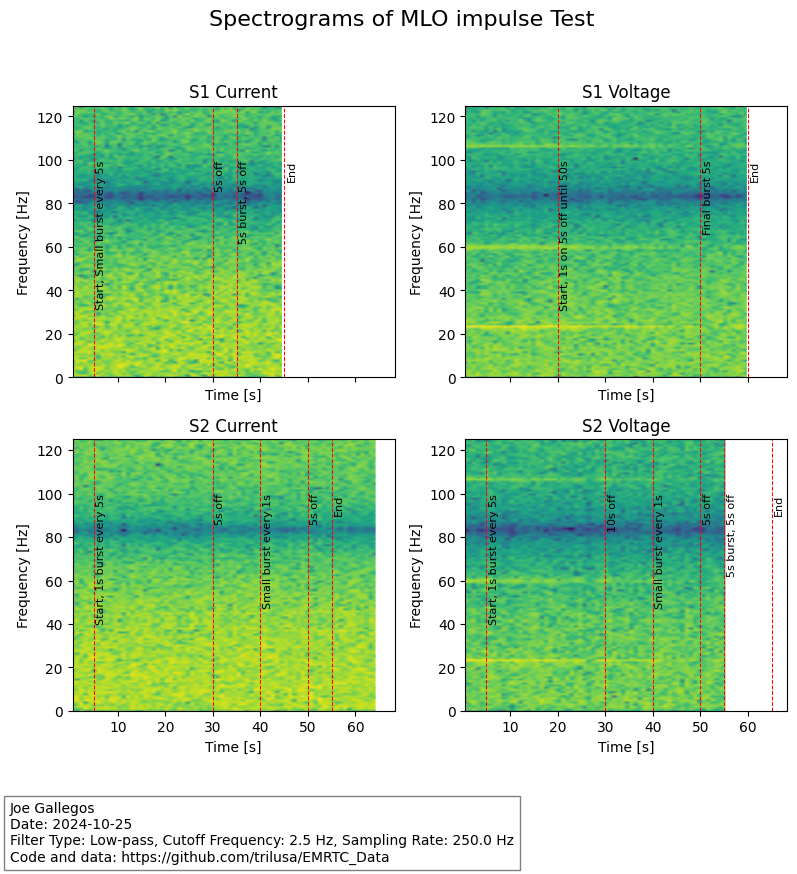

In [54]:
### Spectrogram ###
fig, axs = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=False)
ax_flat = axs.flatten()

for i, (df, event_list) in enumerate(zip(dfs, events)):
    f, t, Sxx = spectrogram(df['A1'], fs=sampling_rate)
    ax_flat[i].pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
    ax_flat[i].set_ylabel('Frequency [Hz]')
    ax_flat[i].set_xlabel('Time [s]')
    ax_flat[i].set_title(titles[i])
    for time, description in event_list:
        ax_flat[i].axvline(x=time, color='r', linestyle='--', linewidth=.75)
        ax_flat[i].text(time + 0.5, f.max() * 0.8, description, rotation=90, verticalalignment='top', fontsize=8, color='black')

fig.suptitle("Spectrograms of MLO impulse Test", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])


bbox_props = dict(facecolor='white', alpha=0.5)
fig.text(0.01, -0.01, metadata, ha='left', va='top', fontsize=10, bbox=bbox_props)

plt.savefig("20241025_MLO_Test.pdf", bbox_inches='tight')
plt.show()